## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 8.8 MB/s eta 0:00:00a 0:00:01


In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=63d2a287-43e1-459c-b0fe-f18763a839e3
To: /Users/arthurchansel/Documents/School/EPFL/MASTER/2 NX-414 Brain-like computation and intelligence/NX-414/Week 6/IT_data.h5
100%|██████████| 384M/384M [00:24<00:00, 15.6MB/s] 


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


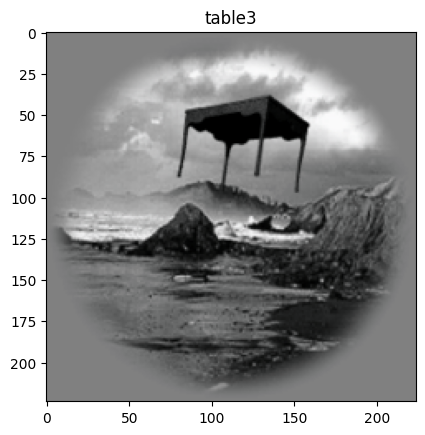

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

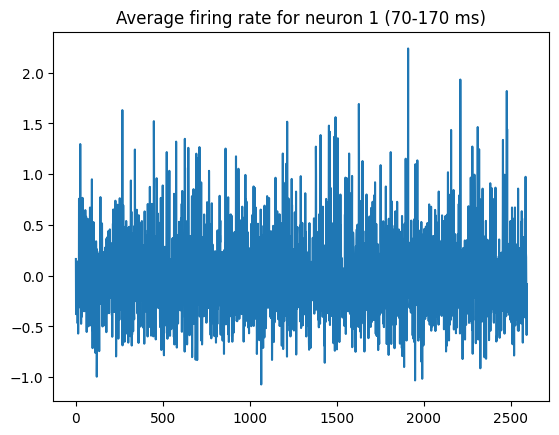

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [91]:
class Model(nn.Module):
    def __init__(self, in_shape, out_shape):
        super(Model, self).__init__()
        self.input_dim = torch.prod(torch.tensor(in_shape[1:])).item()
        self.output_dim = out_shape[1]
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.input_dim, self.output_dim)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        return x
    
    def compute_loss(self, predictions, targets):
        return self.criterion(predictions, targets)

In [92]:
device = 'cpu'
model = Model(in_shape=stimulus_train.shape, out_shape=spikes_train.shape).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [93]:
print(f"Input: images of shape {stimulus_train.shape}")
print(f"Output: neurons spikes of shape {spikes_train.shape}")

# Train
stimulus_train = torch.tensor(stimulus_train, dtype=torch.float32)
spikes_train = torch.tensor(spikes_train, dtype=torch.float32)
train_dataset = TensorDataset(stimulus_train, spikes_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation
stimulus_val = torch.tensor(stimulus_val, dtype=torch.float32)
spikes_val = torch.tensor(spikes_val, dtype=torch.float32)
val_dataset = TensorDataset(stimulus_val, spikes_val)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Prediction
stimulus_test = torch.tensor(stimulus_test, dtype=torch.float32)

Input: images of shape torch.Size([2592, 3, 224, 224])
Output: neurons spikes of shape torch.Size([2592, 168])


/var/folders/5p/fnpzzwjs79g1jdt8bb32xbbc0000gn/T/ipykernel_87461/2341410007.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stimulus_train = torch.tensor(stimulus_train, dtype=torch.float32)
/var/folders/5p/fnpzzwjs79g1jdt8bb32xbbc0000gn/T/ipykernel_87461/2341410007.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spikes_train = torch.tensor(spikes_train, dtype=torch.float32)
/var/folders/5p/fnpzzwjs79g1jdt8bb32xbbc0000gn/T/ipykernel_87461/2341410007.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stimulus_val = torch.tensor(s

In [94]:
epochs = 10
epoch_losses = []
val_losses = []

for epoch in range(epochs):
    total_loss = 0
    for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", ncols=100, leave=False):
        optimizer.zero_grad()
        predictions = model(images)
        loss = model.compute_loss(predictions, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss/len(train_dataloader)
    epoch_losses.append(avg_train_loss)

    # model.eval()
    # val_loss = 0
    # with torch.no_grad():
    #     for val_images, val_targets in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs}", ncols=100, leave=False):
    #         val_predictions = model(val_images)
    #         val_loss += model.compute_loss(val_predictions, val_targets).item()
    
    # avg_val_loss = val_loss / len(val_dataloader)
    # val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}")
    # print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

Epoch 1/10, Training Loss: 1.2797032162363147


Epoch 2/10, Training Loss: 0.26102521813210144


Epoch 3/10, Training Loss: 0.2571161170432597


Epoch 4/10, Training Loss: 0.2873369311844861


Epoch 5/10, Training Loss: 0.3266813885650517


Epoch 6/10, Training Loss: 0.3555417969638919


Epoch 7/10, Training Loss: 0.31791840548868533


Epoch 8/10, Training Loss: 0.2751884046528075


Epoch 9/10, Training Loss: 0.3479422860675388


Epoch 10/10, Training Loss: 0.34839643942721094


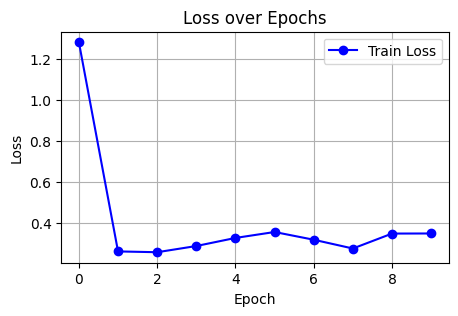

In [96]:
plt.figure(figsize=(5,3))
plt.plot(range(epochs), epoch_losses, marker='o', linestyle='-', color='b', label='Train Loss')
# plt.plot(range(epochs), val_losses, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
# Predictions
predicted_spikes = model(stimulus_val)
predicted_spikes = predicted_spikes.detach().numpy()

print(f"Input: images of shape {stimulus_val.shape}")
print(f"Output: neurons spikes of shape {predicted_spikes.shape}")

Input: images of shape torch.Size([288, 3, 224, 224])
Output: neurons spikes of shape (288, 168)


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

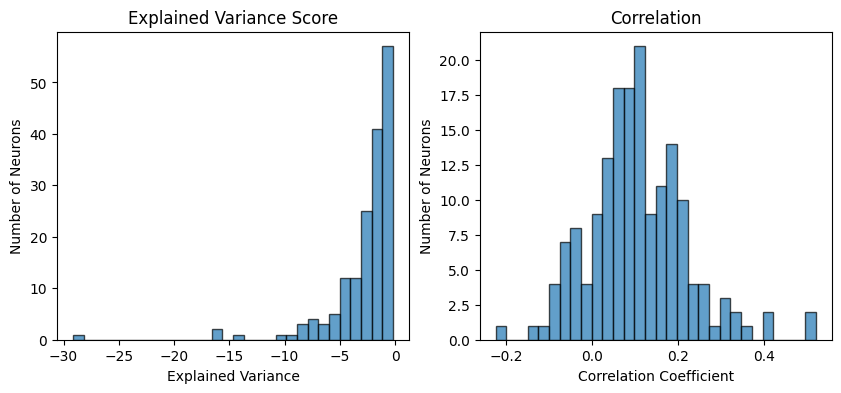

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

correlations = []
explained_variances = []

for neuron in range(predicted_spikes.shape[1]):
    predicted = predicted_spikes[:, neuron]
    actual = spikes_val[:, neuron]
    
    # Calculate correlation coefficient
    corr = np.corrcoef(predicted, actual)[0, 1]
    correlations.append(corr)
    
    # Calculate explained variance
    ev = explained_variance_score(actual, predicted)
    explained_variances.append(ev)

# Convert to numpy arrays for easier manipulation
correlations = np.array(correlations)
explained_variances = np.array(explained_variances)

fig, axs = plt.subplots(1,2, figsize=(10, 4))

# Plot distribution of explained variance across neurons
axs[0].hist(explained_variances, bins=30, edgecolor='black', alpha=0.7)
axs[0].set_title('Explained Variance Score')
axs[0].set_xlabel('Explained Variance')
axs[0].set_ylabel('Number of Neurons')

# Optionally: You can also plot the correlation distribution
axs[1].hist(correlations, bins=30, edgecolor='black', alpha=0.7)
axs[1].set_title('Correlation')
axs[1].set_xlabel('Correlation Coefficient')
axs[1].set_ylabel('Number of Neurons')

plt.show()

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [ ]:
#### Here your code

# compute PCA

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [ ]:
#### Here your code

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [ ]:
#### Here your code